In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [3]:
tf.set_random_seed(777)

In [4]:
def data_standardization(x):
    x_np=np.asarray(x)
    return (x_np - x_np.mean())/x_np.std()
def min_max_scaling(x):
    x_np=np.asarray(x)
    return (x_np - x_np.min())/(x_np.max()-x_np.min()+1e-7)
def reverse_min_max_scaling(org_x,x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [5]:
input_data_column_cnt = 6
output_data_column_cnt = 1

seq_length = 28
rnn_cell_hidden_dim = 20
forget_bias = 1.0
num_stacked_layers = 1
keep_prob = 1.0

epoch_num = 1000
learning_rate = 0.01

In [6]:
stock_file_name = 'C:\\Users\\USER\\datasets\\amazon\\AMZN.csv'
#dir = "C:\\Users\\USER\\datasets\\amazon\\"
encoding = 'eUc-kr'
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding)
raw_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5179 entries, 0 to 5178
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       5179 non-null   object
 1   Open       5179 non-null   object
 2   High       5179 non-null   object
 3   Low        5179 non-null   object
 4   Close      5179 non-null   object
 5   Adj Close  5179 non-null   object
 6   Volume     5179 non-null   object
dtypes: object(7)
memory usage: 283.4+ KB


In [7]:
del raw_dataframe['Date']

In [8]:
stock_info = raw_dataframe.values[1:].astype(np.float)
print("stock_info.shape: ",stock_info.shape)
print("stock_info[0]:", stock_info[0])

stock_info.shape:  (5178, 6)
stock_info[0]: [2.437500e+00 2.500000e+00 1.927083e+00 1.958333e+00 1.958333e+00
 7.215600e+07]


In [9]:
price = stock_info[:,:-1]
norm_price = min_max_scaling(price)
print("price.shape: ", price.shape)
print("price[0]:", price[0])
print("norm_price[0]:", norm_price[0])
print("="*100)

price.shape:  (5178, 5)
price[0]: [2.4375   2.5      1.927083 1.958333 1.958333]
norm_price[0]: [0.00092814 0.00097971 0.00050704 0.00053282 0.00053282]


In [10]:
volume = stock_info[:,-1:]
norm_volume = min_max_scaling(volume)
print("volume.shape:", volume.shape)
print("volume[0]:", volume[0])
print("norm_vloume[0]:", norm_volume[0])
print("="*100)

volume.shape: (5178, 1)
volume[0]: [72156000.]
norm_vloume[0]: [0.69017161]


In [11]:
x = np.concatenate((norm_price, norm_volume), axis=1)
print("x.shape: ", x.shape)
print("x[0]:", x[0])
print("x[-1]:", x[-1])
print("="*100)

x.shape:  (5178, 6)
x[0]: [9.28143131e-04 9.79706638e-04 5.07040880e-04 5.32822633e-04
 5.32822633e-04 6.90171607e-01]
x[-1]: [0.96451605 0.96645482 0.95354329 0.95758589 0.95758589 0.02142033]


In [12]:
y =x[:, [-2]]
print("y[0]: ", y[0])
print("y[-1]: ", y[-1])

y[0]:  [0.00053282]
y[-1]:  [0.95758589]


In [13]:
dataX = []
dataY = []
for i in range(0, len(y)-seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length]
    if i is 0:
        print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[9.28143131e-04 9.79706638e-04 5.07040880e-04 5.32822633e-04
  5.32822633e-04 6.90171607e-01]
 [5.41416826e-04 5.50011019e-04 3.26568604e-04 3.43756990e-04
  3.43756990e-04 1.36869475e-01]
 [3.69538744e-04 3.78132112e-04 2.57817536e-04 3.26568604e-04
  3.26568604e-04 5.41168313e-02]
 [3.43756990e-04 3.60944551e-04 2.66411729e-04 2.66411729e-04
  2.66411729e-04 4.79574739e-02]
 [2.66411729e-04 2.75005097e-04 5.15635073e-05 9.45328216e-05
  9.45328216e-05 1.76864852e-01]
 [1.03127015e-04 1.11721207e-04 0.00000000e+00 6.87510680e-05
  6.87510680e-05 1.08719015e-01]
 [7.73452609e-05 1.71878083e-04 1.71875607e-05 1.54690522e-04
  1.54690522e-04 1.48783729e-01]
 [1.63284715e-04 2.75005097e-04 1.20314575e-04 2.23441590e-04
  2.23441590e-04 7.90662738e-02]
 [2.57817536e-04 2.66411729e-04 1.80472275e-04 1.80472275e-04
  1.80472275e-04 3.93597966e-02]
 [1.89066468e-04 1.89066468e-04 1.37502961e-04 1.58987206e-04
  1.58987206e-04 2.87513723e-02]
 [1.54690522e-04 1.63284715e-04 1.37502961e-04 1.5

In [14]:
train_size = int(len(dataY)*0.7)
test_size = len(dataY) - train_size

In [15]:
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

In [16]:
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [17]:
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X:",X)
Y = tf.placeholder(tf.float32, [None,1])
print("Y:",Y)

X: Tensor("Placeholder:0", shape=(?, 28, 6), dtype=float32)
Y: Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [20]:
targets = tf.placeholder(tf.float32, [None,1])
print("targets: ", targets)
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

targets:  Tensor("Placeholder_6:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_7:0", shape=(?, 1), dtype=float32)


In [21]:
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim,
                                       forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

In [23]:
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

In [25]:
hypothesis, _state = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis:", hypothesis)

hypothesis: Tensor("rnn_1/transpose_1:0", shape=(?, 28, 20), dtype=float32)


In [26]:
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:,-1], output_data_column_cnt, activation_fn=tf.identity)

In [27]:
loss = tf.reduce_sum(tf.square(hypothesis -Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [28]:
train_error_summary = []
test_error_summary = []
test_predict = ""

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [39]:
start_time = datetime.datetime.now()
print('학습을 시작합니다!')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1):
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))

학습을 시작합니다!
epoch: 100, train_error(A): 0.0020631072111427784, test_error(B): 0.018144121393561363, B-A: 0.016081014648079872
epoch: 200, train_error(A): 0.0020381228532642126, test_error(B): 0.018957434222102165, B-A: 0.01691931113600731
epoch: 300, train_error(A): 0.0020155422389507294, test_error(B): 0.020222214981913567, B-A: 0.018206672742962837
epoch: 400, train_error(A): 0.0019953029695898294, test_error(B): 0.02177596278488636, B-A: 0.019780660048127174
epoch: 500, train_error(A): 0.0020605477038770914, test_error(B): 0.020070841535925865, B-A: 0.018010294064879417
epoch: 600, train_error(A): 0.0020098385866731405, test_error(B): 0.018464647233486176, B-A: 0.01645480841398239
epoch: 700, train_error(A): 0.001990819815546274, test_error(B): 0.018229838460683823, B-A: 0.016239019110798836
epoch: 800, train_error(A): 0.001977162668481469, test_error(B): 0.01825532875955105, B-A: 0.016278166323900223
epoch: 900, train_error(A): 0.0019665255676954985, test_error(B): 0.018587149679660

In [41]:
end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print('elapsed_time:', elapsed_time)
print('elspsed_time per epoch', elapsed_time/epoch_num)

elapsed_time: 0:05:53.381286
elspsed_time per epoch 0:00:00.353381


In [45]:
print('input_data_column_cnt:', input_data_column_cnt)
print('output_data_cloumn_cnt:',output_data_column_cnt)

print('seq_length:',seq_length)
print('rnn_cell_hidden_dim:',rnn_cell_hidden_dim)
print('forget_bias:',forget_bias)
print('num_stacked_layers:', num_stacked_layers)
print('keep_prob:', keep_prob)

print('epoch_num:', epoch_num)
print('learning_rete:', learning_rate)

print('train_error:', train_error_summary[-1])
print('test_error:', test_error_summary[-1])
print('min_test_error:', np.min(test_error_summary))

input_data_column_cnt: 6
output_data_cloumn_cnt: 1
seq_length: 28
rnn_cell_hidden_dim: 20
forget_bias: 1.0
num_stacked_layers: 1
keep_prob: 1.0
epoch_num: 1000
learning_rete: 0.01
train_error: 0.001958129
test_error: 0.019126097
min_test_error: 0.009717155


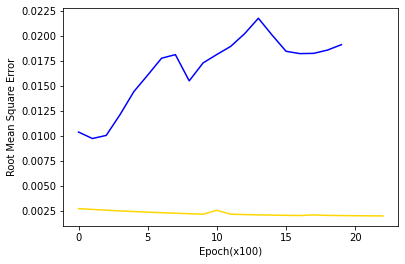

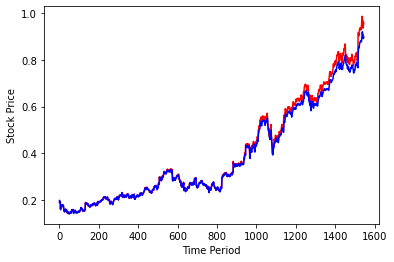

In [46]:
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel("Stock Price")
plt.show()

In [47]:
recent_data = np.array([x[len(x)-seq_length :]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

test_predict = sess.run(hypothesis, feed_dict={X:recent_data})

print("test_predict, test_predict[0]")
test_predict = reverse_min_max_scaling(price,test_predict)
print("Tomorrow's stock price", test_predict[0])

recent_data.shape: (1, 28, 6)
recent_data: [[[0.91386004 0.9151306  0.90735891 0.910791   0.910791   0.02879182]
  [0.91089    0.91383526 0.90374533 0.909471   0.909471   0.03147378]
  [0.90462816 0.90803538 0.89560243 0.90166628 0.90166628 0.0307939 ]
  [0.89913352 0.91689614 0.89696373 0.91600506 0.91600506 0.03143526]
  [0.91398381 0.92739858 0.9136703  0.92347976 0.92347976 0.0278683 ]
  [0.92684578 0.93168037 0.92087268 0.92555055 0.92555055 0.02120337]
  [0.92526172 0.935756   0.92220094 0.93356143 0.93356143 0.02016814]
  [0.92785228 0.93087187 0.91944541 0.93046762 0.93046762 0.03125421]
  [0.92796779 0.93262916 0.92628483 0.92734903 0.92734903 0.01630073]
  [0.92541026 0.93935306 0.92486573 0.93050065 0.93050065 0.02341249]
  [0.93127612 0.93778551 0.92614454 0.93682846 0.93682846 0.0255311 ]
  [0.92871859 0.93262916 0.92428    0.92845453 0.92845453 0.0331417 ]
  [0.93131741 0.93791754 0.93122667 0.93719978 0.93719978 0.01662237]
  [0.93801653 0.93844556 0.92772861 0.93108638 